# モジュールをインポート

In [1]:
# 警告を非表示
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 描画スタイルを定義
plt.style.use("fivethirtyeight")
pd.options.display.max_columns = None

# ランダムシード
np.random.seed(0)

# データ読み込み

In [2]:
train_data = pd.read_csv("./input/train.csv")
test_data = pd.read_csv("./input/test.csv")
match_reports = pd.read_csv("./input/match_reports.csv")
stadium_capacity_mapping = pd.read_csv("./input/stadium_capacity_mapping.csv")
stadium_capacity_mapping = stadium_capacity_mapping.rename(columns={"stadium": "venue"})
holidays_in_japan = pd.read_csv("./input/holidays_in_japan.csv")
holidays_in_japan = holidays_in_japan.rename(columns={"holiday_date": "match_date"})

## メイン学習データ

In [3]:
train_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,attendance
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40,NHK総合/J SPORTS(録),20916
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28,山梨放送/テレビ静岡(録)/J SPORTS(録),14277
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35,BS-i/MXテレビ(録)/J SPORTS(録),22531
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42,J SPORTS,28564
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),17199


## テストデータ

In [4]:
test_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
0,19075,2017-02-25,12:35,第1節,第1日,横浜FM,浦和,日産スタジアム,晴,10.2,45.0,DAZN/テレビ神奈川/テレ玉
1,19076,2017-02-25,14:04,第1節,第1日,仙台,札幌,ユアテックスタジアム仙台,曇,10.6,36.0,DAZN/NHK仙台/NHK札幌
2,19077,2017-02-25,14:04,第1節,第1日,鹿島,FC東京,県立カシマサッカースタジアム,晴,10.1,63.0,DAZN/NHK総合
3,19078,2017-02-25,14:04,第1節,第1日,清水,神戸,IAIスタジアム日本平,晴,15.0,40.0,DAZN/NHK BS1/テレビ静岡
4,19079,2017-02-25,14:04,第1節,第1日,広島,新潟,エディオンスタジアム広島,晴,11.2,45.0,DAZN/NHK広島/NHK新潟


## 試合結果報告

In [5]:
match_reports.head()

,id,home_team_player11,home_team_player10,home_team_player9,home_team_player8,home_team_player7,home_team_player6,home_team_player5,home_team_player4,home_team_player3,home_team_player2,home_team_player1,home_team_score,away_team_score,away_team_player1,away_team_player2,away_team_player3,away_team_player4,away_team_player5,away_team_player6,away_team_player7,away_team_player8,away_team_player9,away_team_player10,away_team_player11
0,9190,9 マグノ アウベス FW,8 フェルナンジーニョ FW,10 二川 孝広 MF,7 遠藤 保仁 MF,27 橋本 英郎 MF,17 明神 智和 MF,14 家長 昭博 DF,6 山口 智 DF,2 シジクレイ DF,21 加地 亮 DF,22 藤ヶ谷 陽介 GK,1,1,23 都築 龍太 GK,2 坪井 慶介 DF,4 田中 マルクス闘莉王 DF,20 堀之内 聖 DF,6 山田 暢久 MF,17 長谷部 誠 MF,13 鈴木 啓太 MF,8 三都主 アレサンドロ MF,18 小野 伸二 MF,10 ポンテ FW,21 ワシントン FW
1,9191,18 長谷川 太郎 FW,16 バレー FW,11 宇留野 純 FW,31 林 健太郎 MF,25 鈴木 健太 MF,8 倉貫 一毅 MF,4 山本 英臣 DF,20 ビジュ DF,15 アライール DF,32 杉山 新 DF,1 阿部 謙作 GK,0,2,21 西部 洋平 GK,25 市川 大祐 DF,26 青山 直晃 DF,4 高木 和道 DF,3 山西 尊裕 DF,13 兵働 昭弘 MF,7 伊東 輝悦 MF,16 枝村 匠馬 MF,10 藤本 淳吾 MF,18 チョ ジェジン FW,17 マルキーニョス FW
2,9192,9 ルーカス FW,21 ササ サルセード FW,35 リチェーリ FW,6 今野 泰幸 MF,23 梶山 陽平 MF,19 伊野波 雅彦 MF,15 鈴木 規郎 DF,5 増嶋 竜也 DF,2 茂庭 照幸 DF,25 徳永 悠平 DF,1 土肥 洋一 GK,2,0,1 西川 周作 GK,2 三木 隆司 DF,4 深谷 友基 DF,22 上本 大海 DF,5 エジミウソン MF,11 トゥーリオ MF,6 梅田 高志 MF,17 根本 裕一 MF,26 内村 圭宏 MF,13 高松 大樹 FW,9 オズマール FW
3,9193,15 西野 泰正 FW,22 カレン ロバート FW,7 名波 浩 MF,14 村井 慎二 MF,23 福西 崇史 MF,25 ファブリシオ MF,11 西 紀寛 MF,6 服部 年宏 DF,5 田中 誠 DF,2 鈴木 秀人 DF,1 川口 能活 GK,1,1,1 水谷 雄一 GK,22 中村 北斗 DF,4 金古 聖司 DF,5 千代反田 充 DF,3 アレックス DF,7 宮崎 光平 MF,6 布部 陽功 MF,8 ホベルト MF,14 古賀 誠史 MF,27 田中 佑昌 FW,36 グラウシオ FW
4,9194,19 杉本 恵太 FW,11 玉田 圭司 FW,27 片山 奨典 MF,7 中村 直志 MF,14 吉村 圭司 MF,8 金 正友 MF,6 有村 光史 DF,29 深津 康太 DF,5 古賀 正紘 DF,4 大森 征之 DF,22 川島 永嗣 GK,3,2,22 吉田 宗弘 GK,2 ブルーノ クアドロス DF,5 前田 和哉 DF,3 柳本 啓成 DF,4 河村 崇大 MF,23 下村 東美 MF,10 ピンゴ MF,6 ゼ カルロス MF,8 森島 寛晃 FW,20 西澤 明訓 FW,9 古橋 達弥 FW


## スタジアム座席数

In [6]:
stadium_capacity_mapping.head()

,venue,capacity
0,日産スタジアム,72081
1,埼玉スタジアム2002,62010
2,国立競技場,54224
3,静岡スタジアムエコパ,51697
4,エコパスタジアム,51697


## 祝祭日

In [7]:
holidays_in_japan.head()

,match_date,description
0,2006-01-01,New Years Day
1,2006-01-02,New Years Holiday
2,2006-01-03,New Years Holiday
3,2006-01-09,Coming-of-age Day
4,2006-02-11,National Foundation Day


# 前処理

## NaNをチェック

In [8]:
NaNs = test_data[test_data.isnull().any(axis=1)]
NaNs.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
459,30000,2018-11-24,14:00,第33節,第1日,仙台,鹿島,ユアテックスタジアム仙台,NaN,NaN,NaN,DAZN/NHK仙台
460,30001,2018-11-24,14:00,第33節,第1日,FC東京,川崎Ｆ,味の素スタジアム,NaN,NaN,NaN,DAZN/TOKYO MX
461,30002,2018-11-24,14:00,第33節,第1日,湘南,浦和,ShonanBMWスタジアム平塚,NaN,NaN,NaN,DAZN
462,30003,2018-11-24,14:00,第33節,第1日,清水,神戸,IAIスタジアム日本平,NaN,NaN,NaN,DAZN/テレビ静岡
463,30004,2018-11-24,14:00,第33節,第1日,磐田,札幌,ヤマハスタジアム(磐田),NaN,NaN,NaN,DAZN


## 天気予報からもらったデータをNaNに入力

### 集めたデータ

In [9]:
external_weather = pd.read_csv("external_weather.csv")
external_weather.head()

,id,match_date,weather,temperature,venue
0,30000,2018-11-24,晴のち雲,12,ユアテックスタジアム仙台
1,30001,2018-11-24,晴のち雲,15,味の素スタジアム
2,30002,2018-11-24,晴のち雲,15,ShonanBMWスタジアム平塚
3,30003,2018-11-24,晴のち雲,15,IAIスタジアム日本平
4,30004,2018-11-24,晴のち雲,14,ヤマハスタジアム(磐田)


## test_dataとext_weatherをマージ

In [10]:
test_data["weather"][459:] = external_weather["weather"]
test_data["temperature"][459:] = external_weather["temperature"]

In [11]:
test_data.loc[459:].head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
459,30000,2018-11-24,14:00,第33節,第1日,仙台,鹿島,ユアテックスタジアム仙台,晴のち雲,12.0,NaN,DAZN/NHK仙台
460,30001,2018-11-24,14:00,第33節,第1日,FC東京,川崎Ｆ,味の素スタジアム,晴のち雲,15.0,NaN,DAZN/TOKYO MX
461,30002,2018-11-24,14:00,第33節,第1日,湘南,浦和,ShonanBMWスタジアム平塚,晴のち雲,15.0,NaN,DAZN
462,30003,2018-11-24,14:00,第33節,第1日,清水,神戸,IAIスタジアム日本平,晴のち雲,15.0,NaN,DAZN/テレビ静岡
463,30004,2018-11-24,14:00,第33節,第1日,磐田,札幌,ヤマハスタジアム(磐田),晴のち雲,14.0,NaN,DAZN


In [12]:
test_data.loc[459:, "humidity"] = test_data["humidity"].mean()

In [13]:
test_data.loc[459:].head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
459,30000,2018-11-24,14:00,第33節,第1日,仙台,鹿島,ユアテックスタジアム仙台,晴のち雲,12.0,57.407407,DAZN/NHK仙台
460,30001,2018-11-24,14:00,第33節,第1日,FC東京,川崎Ｆ,味の素スタジアム,晴のち雲,15.0,57.407407,DAZN/TOKYO MX
461,30002,2018-11-24,14:00,第33節,第1日,湘南,浦和,ShonanBMWスタジアム平塚,晴のち雲,15.0,57.407407,DAZN
462,30003,2018-11-24,14:00,第33節,第1日,清水,神戸,IAIスタジアム日本平,晴のち雲,15.0,57.407407,DAZN/テレビ静岡
463,30004,2018-11-24,14:00,第33節,第1日,磐田,札幌,ヤマハスタジアム(磐田),晴のち雲,14.0,57.407407,DAZN


## 学習データとテストデータを連結する

In [14]:
target = train_data["attendance"]
total_data = pd.concat([train_data.drop(columns="attendance"), test_data])
total_data.tail()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters
472,30013,2018-12-01,14:00,第34節,第1日,川崎Ｆ,磐田,等々力陸上競技場,晴,10.0,57.407407,DAZN
473,30014,2018-12-01,14:00,第34節,第1日,横浜FM,Ｃ大阪,日産スタジアム,晴,10.0,57.407407,DAZN
474,30015,2018-12-01,14:00,第34節,第1日,名古屋,湘南,パロマ瑞穂スタジアム,晴,8.0,57.407407,DAZN
475,30016,2018-12-01,14:00,第34節,第1日,神戸,仙台,ノエビアスタジアム神戸,晴,10.0,57.407407,DAZN/サンテレビ(録)
476,30017,2018-12-01,14:00,第34節,第1日,長崎,清水,トランスコスモススタジアム長崎,晴,11.0,57.407407,DAZN


# 重要ではないデータを削除

In [15]:
# total_data = total_data.drop(columns=["broadcasters"])
for i in range(1, 12):
    match_reports = match_reports.drop(columns = ["home_team_player" + str(i), "away_team_player" + str(i)])

In [16]:
match_reports.head()

,id,home_team_score,away_team_score
0,9190,1,1
1,9191,0,2
2,9192,2,0
3,9193,1,1
4,9194,3,2


## total_dataにスタジアム座席数を追加

In [17]:
total_data = pd.merge(total_data, stadium_capacity_mapping, on="venue", how="left")
del stadium_capacity_mapping

In [18]:
total_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223


## total_dataに試合後報告を追加

### チームが勝ったかどうかを抽出

In [19]:
match_reports["home_team_win"] = match_reports["home_team_score"] > match_reports["away_team_score"]
match_reports["away_team_win"] = match_reports["home_team_score"] < match_reports["away_team_score"]


### total_dataに追加

In [20]:
total_data = total_data.merge(match_reports[["id", "home_team_win", "away_team_win", "home_team_score", "away_team_score"]],
                          how="left",
                          on="id")

In [21]:
total_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0


## 試合日の前処理

### match_dateをpandasのdatetime64タイプに変更

In [22]:
total_data["match_date"] = pd.to_datetime(total_data["match_date"])
holidays_in_japan["match_date"] = pd.to_datetime(holidays_in_japan["match_date"])

### 年月日と曜日を別々の特徴に変更

In [23]:
total_data["match_date_year"] = total_data["match_date"].dt.year
total_data["match_date_month"] = total_data["match_date"].dt.month
total_data["match_date_day"] = total_data["match_date"].dt.day
total_data["match_date_dayofweek"] = total_data["match_date"].dt.dayofweek


In [24]:
total_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6


# 試合日の次の日が祝日かどうかを特徴にする

In [25]:
new_match_date = total_data["match_date"] + np.timedelta64(1, "D")
new_match_date = new_match_date.to_frame()
new_match_date = pd.merge(new_match_date, holidays_in_japan, on="match_date", how="left")
new_match_date = new_match_date.fillna(0)
new_match_date = new_match_date.rename(columns={"description": "next_day_holiday"})
new_match_date["match_date"] = new_match_date["match_date"] - np.timedelta64(1, "D")
new_match_date["id"] = total_data["id"]
new_match_date = new_match_date.drop(columns = ["match_date"])

total_data = total_data.merge(new_match_date, on="id", how="left")

# 試合日が祝日かどうかを特徴にする

In [26]:
new_match_date = total_data["match_date"]
new_match_date = new_match_date.to_frame()
new_match_date = pd.merge(new_match_date, holidays_in_japan, on="match_date", how="left")
new_match_date = new_match_date.fillna(False)
new_match_date = new_match_date.rename(columns={"description": "today_holiday"})
new_match_date["match_date"] = new_match_date["match_date"]
new_match_date["id"] = total_data["id"]
new_match_date = new_match_date.drop(columns = ["match_date"])

total_data = total_data.merge(new_match_date, on="id", how="left")

### 祝日のデータをブール変数に変更

In [27]:
total_data["next_day_holiday"] = total_data["next_day_holiday"].astype(bool)
total_data["today_holiday"] = total_data["today_holiday"].astype(bool)

In [28]:
total_data.head()

,id,match_date,kick_off_time,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday
0,9190,2006-03-04,16:04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False
1,9191,2006-03-05,13:00,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False
2,9192,2006-03-05,13:35,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False
3,9193,2006-03-05,14:04,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False
4,9194,2006-03-05,14:04,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False


## キックオフ時間の前処理

In [29]:
total_data["kick_off_time"] = pd.to_datetime(total_data["kick_off_time"])
total_data["kick_off_hr"] = total_data["kick_off_time"].dt.hour
total_data = total_data.drop(columns=["kick_off_time"])

In [30]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr
0,9190,2006-03-04,第1節,第1日,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16
1,9191,2006-03-05,第1節,第2日,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13
2,9192,2006-03-05,第1節,第2日,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13
3,9193,2006-03-05,第1節,第2日,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14
4,9194,2006-03-05,第1節,第2日,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14


## セクションとラウンドを数字に変更

In [31]:
total_data.loc[:, "section"] = total_data.loc[:, "section"].apply(lambda x: int(x[1:-1]))
total_data.loc[:, "round"] = total_data.loc[:, "round"].apply(lambda x: int(x[1:-1]))

In [32]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14


In [33]:
print("total_data NaNs: ", total_data.isna().sum().sum())

total_data NaNs:  72


## Team name 半角と全角を修正

In [34]:
import re
def make_zen2han_dic(iterable):
    zen = list("ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ" +
               "ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ" +
               "０１２３４５６７８９，、．。（）＿−　")
    han = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,,..()_- ")
    z2h = {}
    pattern = "|".join(zen)
    for it in iterable:
        if re.search(pattern, it) is None:
            continue
        target = it*1
        for z, h in zip(zen, han):
            target = target.replace(z, h)
        z2h[it] = target
    return z2h

teams = set(total_data["home_team"].unique().tolist() + total_data["away_team"].unique().tolist())
z2h = make_zen2han_dic(teams)
total_data["home_team"].replace(z2h, inplace=True)
total_data["away_team"].replace(z2h, inplace=True)

In [35]:
teams = set(total_data["home_team"].unique().tolist() + total_data["away_team"].unique().tolist())
print(teams)

{'大分', '横浜FM', '鹿島', '磐田', 'FC東京', '千葉', '甲府', '松本', '大宮', '札幌', '広島', '鳥栖', '新潟', '東京V', '川崎F', '柏', '福岡', '京都', '仙台', '名古屋', '山形', 'C大阪', '湘南', '徳島', '横浜FC', '清水', '神戸', '長崎', 'G大阪', '浦和'}


In [36]:
for team in teams:
    total_data["team_" + team] = (total_data["home_team"] == team) | (total_data["away_team"] == team)

## 試合シーズンの優勝者と準優勝だったかどうかまたはその試合までの優勝数を追加

In [37]:
# Data retrieved from wikipedia
# https://ja.wikipedia.org/wiki/%E6%97%A5%E6%9C%AC%E3%81%AE%E5%85%A8%E5%9B%BD%E3%82%B5%E3%83%83%E3%82%AB%E3%83%BC%E3%83%AA%E3%83%BC%E3%82%B0%E6%AD%B4%E4%BB%A3%E5%84%AA%E5%8B%9D%E3%83%81%E3%83%BC%E3%83%A0_(1%E9%83%A8)#J1%E3%83%AA%E3%83%BC%E3%82%B0(1999-%E7%8F%BE%E5%9C%A8)
years = np.arange(1999, 2018)
teams_first = ["磐田","鹿島","鹿島","磐田","横浜FM","横浜FM",
         "G大阪","浦和","鹿島","鹿島","鹿島","名古屋",
         "柏","広島","広島","G大阪","広島","鹿島", "川崎"]
champion_team_wins = [3, 3, 4, 4, 4, 5, 1, 5, 5, 6, 7, 1, 2, 6, 7, 2, 8, 8, 1]
teams_second = ["清水エスパルス","横浜FM","磐田","横浜FM","磐田","浦和","浦和",
                "川崎F","浦和","川崎F","川崎F","G大阪","名古屋","仙台","横浜FM",
                "浦和","G大阪","浦和","鹿島"]
df = {"match_date_year": years +1, "champion": teams_first, "champion_team_wins": champion_team_wins, "runnerup": teams_second}
finalists = pd.DataFrame(df)
finalists = finalists[finalists["match_date_year"] >= 2005]
# finalists["champion"] = finalists
# finalists = pd.get_dummies(finalists)
finalists.head() 
# total_data = total_data.merge(finalists, on="match_date_year", how="left")
# total_data.head()

,match_date_year,champion,champion_team_wins,runnerup
5,2005,横浜FM,5,浦和
6,2006,G大阪,1,浦和
7,2007,浦和,5,川崎F
8,2008,鹿島,5,浦和
9,2009,鹿島,6,川崎F


In [38]:
total_data = total_data.merge(finalists, on="match_date_year", how="left")
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,champion_team_wins,runnerup
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,1,浦和
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,1,浦和
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,1,浦和
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,1,浦和
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,1,浦和


In [39]:
total_data["home_team_champion"] = total_data["home_team"] == total_data["champion"]
total_data["away_team_champion"] = total_data["away_team"] == total_data["champion"]
total_data["home_team_runnerup"] = total_data["home_team"] == total_data["runnerup"]
total_data["away_team_runnerup"] = total_data["away_team"] == total_data["runnerup"]

In [40]:
total_data["home_champion_team_wins"] = total_data["champion_team_wins"] * total_data["home_team_champion"]
total_data["away_champion_team_wins"] = total_data["champion_team_wins"] * total_data["away_team_champion"]
total_data = total_data.drop(columns="champion_team_wins")

In [41]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,runnerup,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,浦和,True,False,False,True,1,0
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,浦和,False,False,False,False,0,0
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0


## 各チームの優勝数を追加

In [42]:
team_wins = pd.DataFrame(list(teams), columns=["team"])
win_sum = []
for team in teams:
    win_sum.append(total_data[total_data["home_team"] == team]["home_team_win"].sum() + total_data[total_data["away_team"] == team]["away_team_win"].sum())
team_wins["wins"] = win_sum


In [43]:
team_wins = team_wins.rename(columns={"team": "home_team", "wins": "home_team_wins"})
total_data = total_data.merge(team_wins, on="home_team", how="left")
team_wins = team_wins.rename(columns={"home_team": "away_team", "home_team_wins": "away_team_wins"})
total_data = total_data.merge(team_wins, on="away_team", how="left")

In [44]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,runnerup,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,浦和,True,False,False,True,1,0,188,208
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,69,150
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,163,51
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,124,15
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,164,94


## 天気をブールに変更

In [45]:
for condition in ["晴", "曇", "雨", "屋内", "雷", "雪", "霧", "のち", "時々", "一時"]:
    total_data["weather_{}".format(condition)] = total_data["weather"].str.contains(condition)

In [46]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,runnerup,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,NHK総合/J SPORTS(録),21000,False,False,1.0,1.0,2006,3,4,5,False,False,16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,浦和,True,False,False,True,1,0,188,208,True,False,False,False,False,False,False,False,False,False
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,山梨放送/テレビ静岡(録)/J SPORTS(録),15859,False,True,0.0,2.0,2006,3,5,6,False,False,13,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,69,150,True,False,False,False,False,False,False,False,False,False
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,BS-i/MXテレビ(録)/J SPORTS(録),48999,True,False,2.0,0.0,2006,3,5,6,False,False,13,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,163,51,True,False,False,False,False,False,False,False,False,False
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,J SPORTS,51697,False,False,1.0,1.0,2006,3,5,6,False,False,14,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,124,15,True,False,False,False,False,False,False,False,False,False
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,スカイパーフェクTV!/NHK名古屋(録)/NHK大阪(録)/J SPORTS(録),20223,True,False,3.0,2.0,2006,3,5,6,False,False,14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,164,94,True,False,False,False,False,False,False,False,False,False


## 放送局のデータを奇麗にする

In [47]:
dirty_casters = set()
for casters in total_data["broadcasters"].str.split("/"):
    dirty_casters.update(casters)

In [48]:
clean_casters = set()
def cleanify(caster):
    caster = caster.upper()
    caster = re.sub("\(.+\)|\*", "", caster)
    caster = caster.split("※")[0]\
               .rstrip(" ")\
               .replace("ー", "-")\
               .replace(" ", "_")
    if caster[:4] == "スカパ-":
        caster = "スカパー"
    return caster

for caster in dirty_casters:
    clean_casters.add(cleanify(caster))

In [49]:
tmp = total_data["broadcasters"].str.split("/")\
                              .apply(lambda casters: [cleanify(caster) for caster in casters])
total_data["broadcasters"] = tmp

In [50]:
for caster in clean_casters:
    total_data["broadcasters_{}".format(caster)] = total_data["broadcasters"].apply(lambda casters: caster in casters)

### 放送が少ない放送局を削除

In [51]:
caster_counts = total_data.filter(regex="broadcasters_").sum(axis=0)
total_data.drop(caster_counts[caster_counts < 30].index.tolist(), axis=1, inplace=True)

In [52]:
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,runnerup,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時,broadcasters_DAZN,broadcasters_スカイパ-フェクTV!,broadcasters_BS,broadcasters_テレ玉,broadcasters_BS-TBS,broadcasters_BS-I,broadcasters_E2,broadcasters_スカパー,broadcasters_NHK_BS1,broadcasters_テレビ静岡,broadcasters_KBS京都,broadcasters_NHK総合,broadcasters_NHK名古屋,broadcasters_TOKYO_MX,broadcasters_NHK新潟,broadcasters_E2スカチャン,broadcasters_NHK広島,broadcasters_TBS,broadcasters_ひかりTV,broadcasters_静岡放送,broadcasters_J_SPORTS,broadcasters_NHK静岡,broadcasters_NHK仙台,broadcasters_E2スカチャンHD
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,"[NHK総合, J_SPORTS]",21000,False,False,1.0,1.0,2006,3,4,5,False,False,16,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,浦和,True,False,False,True,1,0,188,208,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,"[山梨放送, テレビ静岡, J_SPORTS]",15859,False,True,0.0,2.0,2006,3,5,6,False,False,13,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,69,150,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,"[BS-I, MXテレビ, J_SPORTS]",48999,True,False,2.0,0.0,2006,3,5,6,False,False,13,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,163,51,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,[J_SPORTS],51697,False,False,1.0,1.0,2006,3,5,6,False,False,14,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,124,15,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,"[スカイパ-フェクTV!, NHK名古屋, NHK大阪, J_SPORTS]",20223,True,False,3.0,2.0,2006,3,5,6,False,False,14,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,164,94,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,Fals

# 他行特徴を追加

In [53]:
# total_data["capacity"] = total_data["capacity"]**2
# total_data["humidity"] = total_data["humidity"]**2
# total_data["temperature"] = total_data["temperature"]**2
# total_data["section"] = total_data["section"]**2
total_data["home_team_wins"] = total_data["home_team_wins"]**2
total_data["away_team_wins"] = total_data["away_team_wins"]**2
total_data["match_date_dayofweek"] = total_data["match_date_dayofweek"]**2
total_data["kick_off_hr"] = total_data["kick_off_hr"]**2
total_data["home_team_win"] = total_data["home_team_win"]**2
# total_data["match_date_year"] = (total_data["match_date_year"] - 2000)**2

In [54]:
total_data["capacity^2"] = total_data["capacity"]**2

In [55]:
# total_data["match_date_year"] ** 2
total_data.head()

,id,match_date,section,round,home_team,away_team,venue,weather,temperature,humidity,broadcasters,capacity,home_team_win,away_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,champion,runnerup,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時,broadcasters_DAZN,broadcasters_スカイパ-フェクTV!,broadcasters_BS,broadcasters_テレ玉,broadcasters_BS-TBS,broadcasters_BS-I,broadcasters_E2,broadcasters_スカパー,broadcasters_NHK_BS1,broadcasters_テレビ静岡,broadcasters_KBS京都,broadcasters_NHK総合,broadcasters_NHK名古屋,broadcasters_TOKYO_MX,broadcasters_NHK新潟,broadcasters_E2スカチャン,broadcasters_NHK広島,broadcasters_TBS,broadcasters_ひかりTV,broadcasters_静岡放送,broadcasters_J_SPORTS,broadcasters_NHK静岡,broadcasters_NHK仙台,broadcasters_E2スカチャンHD,capacity^2
0,9190,2006-03-04,1,1,G大阪,浦和,万博記念競技場,晴,8.3,40.0,"[NHK総合, J_SPORTS]",21000,0,False,1.0,1.0,2006,3,4,25,False,False,256,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,G大阪,浦和,True,False,False,True,1,0,35344,43264,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,441000000
1,9191,2006-03-05,1,2,甲府,清水,山梨県小瀬スポーツ公園陸上競技場,晴,12.9,28.0,"[山梨放送, テレビ静岡, J_SPORTS]",15859,0,True,0.0,2.0,2006,3,5,36,False,False,169,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,4761,22500,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,251507881
2,9192,2006-03-05,1,2,FC東京,大分,味の素スタジアム,晴,12.1,35.0,"[BS-I, MXテレビ, J_SPORTS]",48999,1,False,2.0,0.0,2006,3,5,36,False,False,169,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,26569,2601,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2400902001
3,9193,2006-03-05,1,2,磐田,福岡,静岡スタジアムエコパ,晴,11.6,42.0,[J_SPORTS],51697,0,False,1.0,1.0,2006,3,5,36,False,False,196,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,15376,225,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2672579809
4,9194,2006-03-05,1,2,名古屋,C大阪,名古屋市瑞穂陸上競技場,晴,13.1,32.0,"[スカイパ-フェクTV!, NHK名古屋, NHK大阪, J_SPORTS]",20223,1,False,3.0,2.0,2006,3,5,36,False,False,196,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,G大阪,浦和,False,False,False,False,0,0,26896,8836,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,Fals

In [56]:
print(total_data.shape)

(3843, 98)


## 必要のないデータを削除

In [57]:
total_data = total_data.dropna()
bool_col = total_data.filter(regex="^weather_").columns.tolist() + ["home_team_win"]
total_data.loc[:, bool_col] = total_data.loc[:, bool_col].astype(np.bool8)

In [58]:
del_col = total_data.select_dtypes(["object", np.datetime64]).columns
total_data.drop(del_col, axis=1, inplace=True)

In [59]:
total_data.head()

,id,section,round,temperature,humidity,capacity,home_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時,broadcasters_DAZN,broadcasters_スカイパ-フェクTV!,broadcasters_BS,broadcasters_テレ玉,broadcasters_BS-TBS,broadcasters_BS-I,broadcasters_E2,broadcasters_スカパー,broadcasters_NHK_BS1,broadcasters_テレビ静岡,broadcasters_KBS京都,broadcasters_NHK総合,broadcasters_NHK名古屋,broadcasters_TOKYO_MX,broadcasters_NHK新潟,broadcasters_E2スカチャン,broadcasters_NHK広島,broadcasters_TBS,broadcasters_ひかりTV,broadcasters_静岡放送,broadcasters_J_SPORTS,broadcasters_NHK静岡,broadcasters_NHK仙台,broadcasters_E2スカチャンHD,capacity^2
0,9190,1,1,8.3,40.0,21000,False,1.0,1.0,2006,3,4,25,False,False,256,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,1,0,35344,43264,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,441000000
1,9191,1,2,12.9,28.0,15859,False,0.0,2.0,2006,3,5,36,False,False,169,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0,0,4761,22500,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,251507881
2,9192,1,2,12.1,35.0,48999,True,2.0,0.0,2006,3,5,36,False,False,169,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,26569,2601,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2400902001
3,9193,1,2,11.6,42.0,51697,False,1.0,1.0,2006,3,5,36,False,False,196,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,15376,225,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2672579809
4,9194,1,2,13.1,32.0,20223,True,3.0,2.0,2006,3,5,36,False,False,196,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,0,26896,8836,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,408969729


# 学習と検証

## ターゲットを抽出

In [60]:
train_data = total_data.query("id < 19075")
train_data["attendance"] = target.values
train_data = train_data.drop(2479)  # 無観客試合
test_data = total_data.query("id >= 19075")

In [61]:
train_data_y = train_data[["match_date_year", "attendance"]]
train_data = train_data.drop(columns=["id", "attendance"])
test_data = test_data.drop(columns=["id"])

## 学習データを学習とテストデータに分割

In [62]:
all_train_X = train_data.query("match_date_year <= 2016")
all_train_y = np.log1p(train_data_y.query("match_date_year <= 2016")["attendance"])
test_X = test_data

In [63]:
all_train_X.head()

,section,round,temperature,humidity,capacity,home_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時,broadcasters_DAZN,broadcasters_スカイパ-フェクTV!,broadcasters_BS,broadcasters_テレ玉,broadcasters_BS-TBS,broadcasters_BS-I,broadcasters_E2,broadcasters_スカパー,broadcasters_NHK_BS1,broadcasters_テレビ静岡,broadcasters_KBS京都,broadcasters_NHK総合,broadcasters_NHK名古屋,broadcasters_TOKYO_MX,broadcasters_NHK新潟,broadcasters_E2スカチャン,broadcasters_NHK広島,broadcasters_TBS,broadcasters_ひかりTV,broadcasters_静岡放送,broadcasters_J_SPORTS,broadcasters_NHK静岡,broadcasters_NHK仙台,broadcasters_E2スカチャンHD,capacity^2
0,1,1,8.3,40.0,21000,False,1.0,1.0,2006,3,4,25,False,False,256,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,1,0,35344,43264,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,441000000
1,1,2,12.9,28.0,15859,False,0.0,2.0,2006,3,5,36,False,False,169,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0,0,4761,22500,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,251507881
2,1,2,12.1,35.0,48999,True,2.0,0.0,2006,3,5,36,False,False,169,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,26569,2601,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2400902001
3,1,2,11.6,42.0,51697,False,1.0,1.0,2006,3,5,36,False,False,196,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,15376,225,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,2672579809
4,1,2,13.1,32.0,20223,True,3.0,2.0,2006,3,5,36,False,False,196,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0,0,26896,8836,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,408969729


## データを正規化

In [64]:
feature_names = list(all_train_X.columns)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(all_train_X)
all_train_X = scaler.transform(all_train_X)
test_X = scaler.transform(test_X)

C:\Users\samuw\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [65]:
all_train_X = pd.DataFrame(all_train_X, columns = feature_names)
test_X = pd.DataFrame(test_X, columns = feature_names)
all_train_X.head()

,section,round,temperature,humidity,capacity,home_team_win,home_team_score,away_team_score,match_date_year,match_date_month,match_date_day,match_date_dayofweek,next_day_holiday,today_holiday,kick_off_hr,team_大分,team_横浜FM,team_鹿島,team_磐田,team_FC東京,team_千葉,team_甲府,team_松本,team_大宮,team_札幌,team_広島,team_鳥栖,team_新潟,team_東京V,team_川崎F,team_柏,team_福岡,team_京都,team_仙台,team_名古屋,team_山形,team_C大阪,team_湘南,team_徳島,team_横浜FC,team_清水,team_神戸,team_長崎,team_G大阪,team_浦和,home_team_champion,away_team_champion,home_team_runnerup,away_team_runnerup,home_champion_team_wins,away_champion_team_wins,home_team_wins,away_team_wins,weather_晴,weather_曇,weather_雨,weather_屋内,weather_雷,weather_雪,weather_霧,weather_のち,weather_時々,weather_一時,broadcasters_DAZN,broadcasters_スカイパ-フェクTV!,broadcasters_BS,broadcasters_テレ玉,broadcasters_BS-TBS,broadcasters_BS-I,broadcasters_E2,broadcasters_スカパー,broadcasters_NHK_BS1,broadcasters_テレビ静岡,broadcasters_KBS京都,broadcasters_NHK総合,broadcasters_NHK名古屋,broadcasters_TOKYO_MX,broadcasters_NHK新潟,broadcasters_E2スカチャン,broadcasters_NHK広島,broadcasters_TBS,broadcasters_ひかりTV,broadcasters_静岡放送,broadcasters_J_SPORTS,broadcasters_NHK静岡,broadcasters_NHK仙台,broadcasters_E2スカチャンHD,capacity^2
0,0.0,0.0,0.224551,0.321839,0.141453,0.0,0.125,0.142857,0.0,0.1,0.100000,0.694444,0.0,0.0,0.437500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.125,0.0,0.723603,0.885792,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.056110
1,0.0,0.5,0.362275,0.183908,0.055045,0.0,0.000,0.285714,0.0,0.1,0.133333,1.000000,0.0,0.0,0.097656,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.097313,0.460579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.018492
2,0.0,0.5,0.338323,0.264368,0.612048,1.0,0.250,0.000000,0.0,0.1,0.133333,1.000000,0.0,0.0,0.097656,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.543906,0.053080,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.445187
3,0.0,0.5,0.323353,0.344828,0.657394,0.0,0.125,0.142857,0.0,0.1,0.133333,1.000000,0.0,0.0,0.203125,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.314691,0.004423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.499120
4,0.0,0.5,0.368263,0.229885,0.128393,1.0,0.375,0.285714,0.0,0.1,0.133333,1.000000,0.0,0.0,0.203125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.550602,0.180763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.049751


# 学習

## ランダムフォレスト

In [66]:
from sklearn.metrics import mean_squared_error

In [67]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)

## ランダムフォレスト交差検証

In [68]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rfr, all_train_X, all_train_y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [69]:
print("K-Fold cross val score:", np.sqrt(-scores))
print("Mean: ", np.sqrt(-scores).mean())
print("Var: ", np.sqrt(-scores).std())

K-Fold cross val score: [0.28815556 0.22942226 0.24298838 0.24673482 0.26004563]
Mean:  0.25346932876503436
Var:  0.019898984743226687


In [70]:
# plt.figure(figsize=(6, 15))
# plt.barh(train_X.columns, rfr.feature_importances_)

In [71]:
# rfr.fit(all_train_X, all_train_y)
# test_pred = rfr.predict(test_X)
# smpsb_df = pd.read_csv("./input/sample_submit.csv", header=None)
# smpsb_df.iloc[:len(test_X), 1] = np.expm1(rfr.predict(test_X))

In [72]:
# smpsb_df.to_csv("tutorial_result2.csv", index=None, header=None)

## XGBoost

In [73]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [74]:
model = xgb.XGBRegressor(n_jobs=-1,
                         max_depth=10,
                         n_estimators=1700,
                         learning_rate=0.05,
                         random_state=0,
                         gamma=0.3,
                         subsample=0.8,
                        reg_lambda=4)
#param_dist = {"max_depth": [10,30,50],
#              "min_child_weight" : [1,3,6],
#              "n_estimators": [200],
#              "learning_rate": [0.05, 0.1,0.16],}

## XGBoost交差検証

In [75]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, all_train_X, all_train_y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

C:\Users\samuw\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [76]:
print("K-Fold cross val score:", np.sqrt(-scores))
print("Mean: ", np.sqrt(-scores).mean())
print("Var: ", np.sqrt(-scores).std())

K-Fold cross val score: [0.27320401 0.21328259 0.21610366 0.23036736 0.26297698]
Mean:  0.23918692200968975
Var:  0.024514424795268795


## XGBoostをフィット

In [77]:
model.fit(all_train_X, all_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.3, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1700,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=4, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

## 重要度を可視化

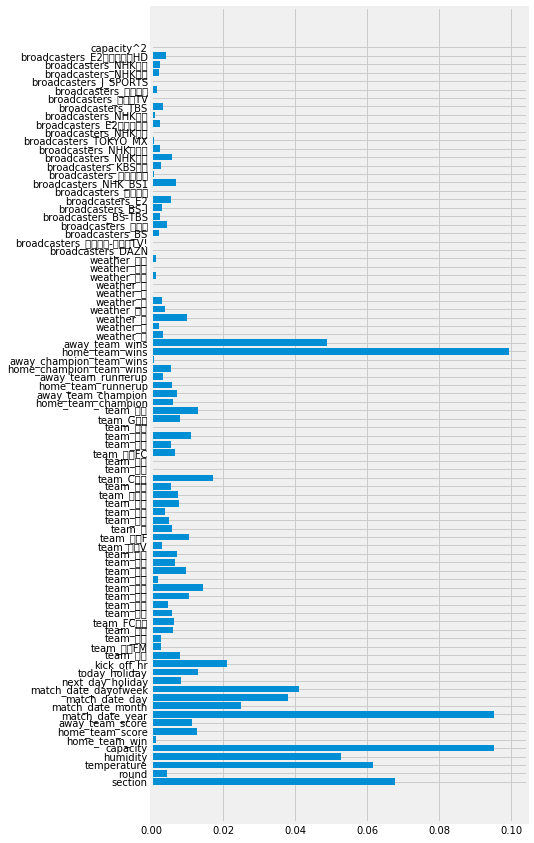

In [78]:
plt.figure(figsize=(6, 15))
plt.barh(all_train_X.columns, model.feature_importances_);

# 提出ファイルを作成

In [79]:
smpsb_df = pd.read_csv("./input/sample_submit.csv", header=None)
smpsb_df.iloc[:len(test_X), 1] = np.expm1(model.predict(test_X))

In [80]:
smpsb_df.head()
# smpsb_df.to_csv("xgboost5.csv", index=None, header=None)

,0,1
0,19075,41194.421875
1,19076,17225.542969
2,19077,26290.751953
3,19078,17163.472656
4,19079,17564.318359
